In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = '../data/processed/final_training_data.csv'
df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['is_high_risk'].value_counts(normalize=True)}")

Dataset shape: (3742, 36)
Target distribution:
is_high_risk
0    0.618653
1    0.381347
Name: proportion, dtype: float64


In [3]:
from src.another_one5 import main as train_main

In [4]:
print("Starting model training...")
train_main()
print("Training completed!")

Starting model training...


2025/12/16 04:09:34 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/16 04:09:34 INFO mlflow.store.db.utils: Updating database tables
2025/12/16 04:09:34 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/16 04:09:34 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/16 04:09:35 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/16 04:09:35 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Training data shape: (2993, 34)
Test data shape: (749, 34)
Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...


2025/12/16 04:10:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



LogisticRegression logged to MLflow
Params: {'C': 10, 'solver': 'lbfgs'}
Metrics: {'accuracy': 0.9279038718291055, 'precision': 0.9393939393939394, 'recall': 0.8671328671328671, 'f1': 0.9018181818181819, 'roc_auc': 0.9593861861680437}


2025/12/16 04:10:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/16 04:10:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



RandomForest logged to MLflow
Params: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}
Metrics: {'accuracy': 0.9732977303070761, 'precision': 0.9854014598540146, 'recall': 0.9440559440559441, 'f1': 0.9642857142857143, 'roc_auc': 0.9973266474346388}


2025/12/16 04:10:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



GradientBoosting logged to MLflow
Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Metrics: {'accuracy': 0.9759679572763685, 'precision': 0.975177304964539, 'recall': 0.9615384615384616, 'f1': 0.9683098591549296, 'roc_auc': 0.9963977706958269}

Best model: RandomForest with ROC-AUC: 0.9973
Best model saved to models/best_model.pkl


2025/12/16 04:10:59 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/16 04:10:59 INFO mlflow.store.db.utils: Updating database tables
2025/12/16 04:10:59 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/16 04:10:59 INFO alembic.runtime.migration: Will assume non-transactional DDL.
Successfully registered model 'CreditRisk_Prod'.



Test set saved to data/processed/test_set.csv
Training completed!


Created version '1' of model 'CreditRisk_Prod'.


In [5]:
best_model = joblib.load('../models/best_model.pkl')
print(f"Best model type: {type(best_model).__name__}")

Best model type: RandomForestClassifier


In [6]:
test_set = pd.read_csv('../data/processed/test_set.csv')
X_test = test_set.drop(columns=['is_high_risk'], errors='ignore')
y_test = test_set['is_high_risk']

print(f"Test set shape: {X_test.shape}")

Test set shape: (749, 34)


In [ ]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

In [9]:
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_prob)
}

print("Best Model Performance Metrics:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

Best Model Performance Metrics:
  Accuracy: 0.9733
  Precision: 0.9854
  Recall: 0.9441
  F1-Score: 0.9643
  ROC-AUC: 0.9973


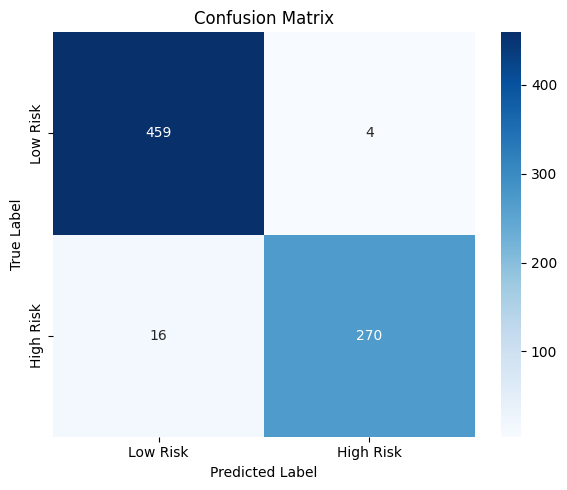

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

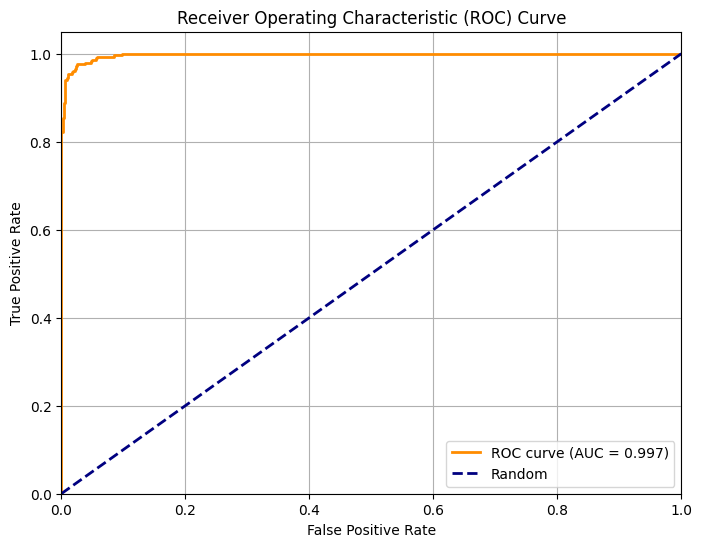

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

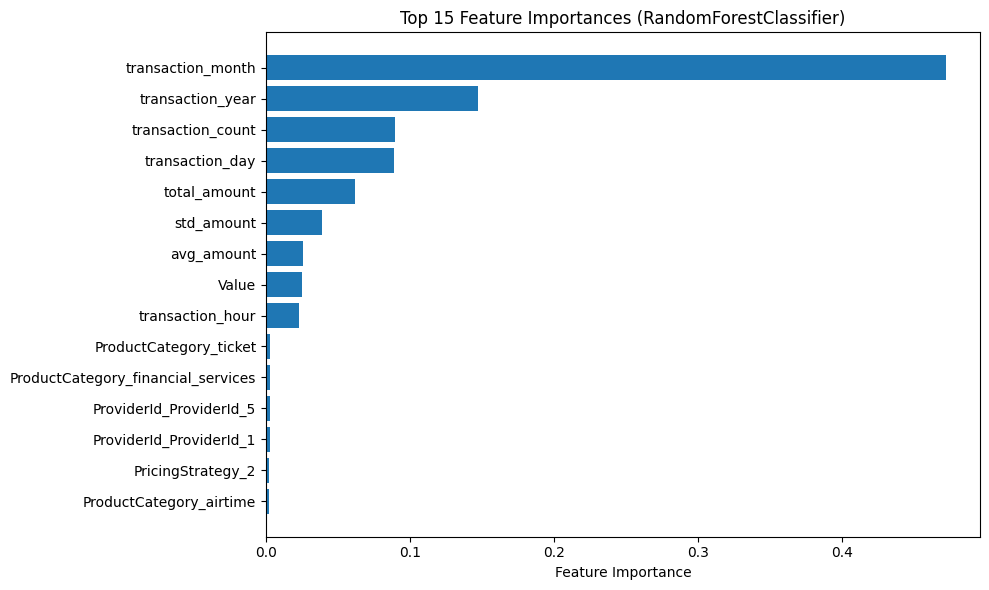

In [12]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_test.columns, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp['feature'], feat_imp['importance'])
    plt.gca().invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances ({type(best_model).__name__})')
    plt.tight_layout()
    plt.show()
else:
    print("Model does not have feature importances (e.g., Logistic Regression).")
